In [ ]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import random
from tqdm import tqdm
import pandas as pd
plt.style.use('ggplot')
from PIL import Image

Доверительный интервал - показатель точности измерений. Его применяют как для оценки среднего, так и для оценки дисперсии. Он также отражает, насколько величина, вычисленная о выборке, близка к значению по генеральной совокупности. Здесь мы разберем построение доверительного интервала для среднего, если выборка из нормального распределения, а также что делать, если истинное распределение выборки неизвестно. В общем виде доверительный интервал задается как через вероятность того, что оцениваемый параметр $\theta$ не выходит за границы:

$$P(LB \leqslant \theta \leqslant UB)=p$$

$p$ - уровень доверия, другими словами вероятность того, что доверительный интервал содержит верное значение. Обычно берут значения 0.95, 0.9 или 0.99. Границы LB и UB нам необходимо найти.

### Нормальное распределение

#### Известная дисперсия

В этом случае формула доверительного интервала выглядит следующим образом:

$${P}\left( \bar{X} - z_{1-\frac{\alpha}{2}} \frac{\sigma}{\sqrt{n}} \le \mu \le \bar{X} + z_{1-\frac{\alpha}{2}} \frac{\sigma}{\sqrt{n}}\right) = 1-\alpha$$

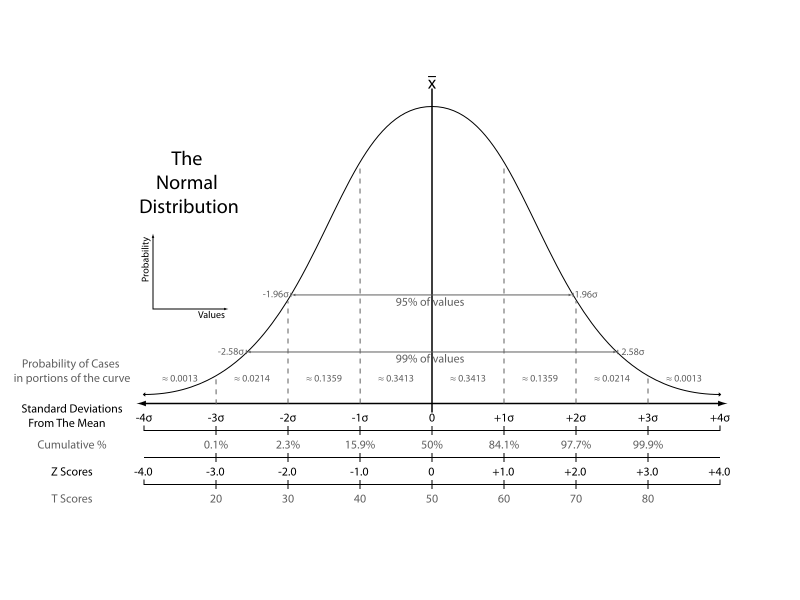

In [3]:
Image.open('800px-The_Normal_Distribution.svg.png')

Давайте зафиксируем некоторое распределение

In [4]:
population = stats.norm.rvs(loc=2, scale=5, size=100000)

Сделаем сэмпл из данного распределения

In [5]:
sample_size = 100
sample = np.random.choice(a = population, size = sample_size)

Найдем выборочное среднее и дисперсию по генеральной совокупности

In [6]:
sample_mean = sample.mean()
st_dev = population.std()

Найдем z-value, соответствующий 95%. 95% - это значение кумулятивной функции, и поэтому для того чтобы найти аргумент этой функции, мы берем обратную функцию ppf

In [7]:
z_value = stats.norm.ppf(q = 0.975)  
print("z-value:", z_value)      

z-value: 1.959963984540054


Для левой границы в силу симметрии нормального распределения

In [8]:
stats.norm.ppf(q = 0.025)

-1.9599639845400545

Найдем сам интервал

In [9]:
interval = z_value * (st_dev/np.sqrt(sample_size))
conf_inv = (sample_mean - interval, sample_mean + interval)  

print("Confidence interval:", conf_inv)

Confidence interval: (1.255919550993109, 3.22581663441918)


In [10]:
def compute_ci(sample, st_dev):
    
    z_value = stats.norm.ppf(q = 0.975)
    sample_size = len(sample)
    interval = z_value * (st_dev/np.sqrt(sample_size))
    conf_inv = (sample_mean - interval, sample_mean + interval)
    
    return conf_inv

Давайте найдем доверительный интервал для выборки из того же распределения, но большего размера. Мы также видим, что разброс уже стал меньше, следовательно вторая оценка предпочтительнее первой, и мы смогли численно это показать.

In [11]:
np.random.seed(5)
sample_size = 2000
sample = np.random.choice(a = population, size = sample_size)

ci = compute_ci(sample, st_dev)

print("conf interval for 2000 sample size:", ci)

conf interval for 2000 sample size: (2.020626903345181, 2.461109282067108)


#### Неизвестная дисперсия

Как вы можете заметить, в предыдущей задаче для поиска дов интервала рассматривалась довольно большая выборка, что позволяло по ней оценить диспресию. На практике не всегда размер выборки бывает большим, и нельзя оценить дисперсию. Здесь на помощь приходит распределение Стьюдента - как мы уже говорили, распределение Стьюдента может заменить нормальное, если неизвестна дисперсия и размер выборки достаточно маленький. 

$${P}\left( \bar{X} - t_{1-\frac{\alpha}{2},n-1} \frac{S}{\sqrt{n}} \le \mu \le \bar{X} + t_{1-\frac{\alpha}{2},n-1} \frac{S}{\sqrt{n}}\right) = 1-\alpha$$

Алгоритм поиска доверительного интервала не отличается, только z-value заменяется на t-value:

In [12]:
def compute_ci_t(sample, alpha=0.95):
    
    n = sample.shape[0]
    mu, se = np.mean(sample), stats.sem(sample)
    bound = se * stats.t.ppf((1 + alpha) / 2., n-1)
    
    return mu - bound, mu + bound

In [13]:
sample = np.random.choice(a = population, size = 30)
ci_t = compute_ci_t(sample, alpha=0.95)
print("conf interval with t test for 2000 sample size:", ci_t)

conf interval with t test for 2000 sample size: (0.2103013921664587, 4.621719670253814)


#### Что делать, если неизвестно распределение

В этом случае нам поможет ЦПТ - вспомним, что распределение средних есть нормальное распределение, а для нормального распределения мы знаем как строить доверительный интервал. Рассмотрим на примере поездок такси в Мехико:

In [14]:
taxi_mex = pd.read_csv('taxi-routes/mex_clean.csv')

In [15]:
def generate_distribution_sample(data, sample_size, dist_size):
    
    sample_means = []
    for i in tqdm(range(dist_size)):
        sample = np.random.choice(a = data, size = sample_size)
        sample_means.append(np.mean(sample))
        
    return sample_means

In [16]:
sample_size = 10000
dist_size = 50000

In [17]:
sample_means = generate_distribution_sample(taxi_mex['dist_meters']/1000, sample_size, dist_size)

100%|██████████| 50000/50000 [00:11<00:00, 4524.23it/s]


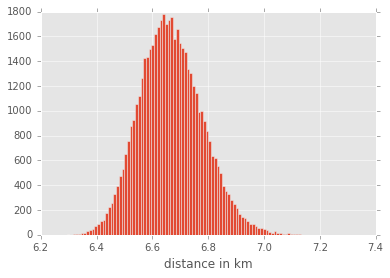

In [18]:
plt.hist(sample_means, bins=100);
plt.xlabel('distance in km');

In [19]:
np.sort(sample_means)
lb = np.percentile(sample_means, 2.5)
ub = np.percentile(sample_means, 97.5)
print("conf interval for bootstrap:", (lb, ub))

conf interval for bootstrap: (6.461480465, 6.903554787500001)


#### Смысл доверительного интервала

Чем шире доверительный интервал, тем более неточная оценка, и наоборот, узкий доверительный интервал дает оценку точнее



In [ ]:
С помощью доверительного интервала можно оценить, какой объем выборки необходим для